In [3]:
from dotenv import load_dotenv
import os

import datasets
from datasets import load_dataset, ClassLabel
import matplotlib.pyplot as plt

from src import get_data
from src.data import SensorSizes

_ = load_dotenv()

In [4]:
# ds_images = get_data.load_and_process_data(
#     dataset_name="aplesner-eth/dvs_gesture",
#     split="train",
#     num_samples=50,
#     num_classes=10,
# )

In [31]:
# Issues with ASL, DVSGesture, PokerDVS

In [51]:
# dataset_name = "aplesner-eth/NMNIST"
# dataset_name = "aplesner-eth/NCALTECH101"
# dataset_name = "aplesner-eth/DVSLip" # The data might not be a good fit for our use case
dataset_name = "aplesner-eth/CIFAR10DVS"

split = "train"
num_samples = 5
num_classes = 10

In [52]:
ds = load_dataset(dataset_name, split=split, token=os.getenv('HF_TOKEN'))

# add a column with a row id
ds = ds.map(lambda x, i: {'row_id': i}, with_indices=True)


README.md:   0%|          | 0.00/874 [00:00<?, ?B/s]

Resolving data files:   0%|          | 0/34 [00:00<?, ?it/s]

data/train-00000-of-00034.parquet:   0%|          | 0.00/334M [00:00<?, ?B/s]

data/train-00001-of-00034.parquet:   0%|          | 0.00/315M [00:00<?, ?B/s]

data/train-00002-of-00034.parquet:   0%|          | 0.00/301M [00:00<?, ?B/s]

data/train-00003-of-00034.parquet:   0%|          | 0.00/376M [00:00<?, ?B/s]

data/train-00004-of-00034.parquet:   0%|          | 0.00/408M [00:00<?, ?B/s]

data/train-00005-of-00034.parquet:   0%|          | 0.00/409M [00:00<?, ?B/s]

data/train-00006-of-00034.parquet:   0%|          | 0.00/388M [00:00<?, ?B/s]

data/train-00007-of-00034.parquet:   0%|          | 0.00/323M [00:00<?, ?B/s]

data/train-00008-of-00034.parquet:   0%|          | 0.00/326M [00:00<?, ?B/s]

data/train-00009-of-00034.parquet:   0%|          | 0.00/308M [00:00<?, ?B/s]

data/train-00010-of-00034.parquet:   0%|          | 0.00/361M [00:00<?, ?B/s]

train-00011-of-00034.parquet:   0%|          | 0.00/355M [00:00<?, ?B/s]

data/train-00012-of-00034.parquet:   0%|          | 0.00/347M [00:00<?, ?B/s]

data/train-00013-of-00034.parquet:   0%|          | 0.00/330M [00:00<?, ?B/s]

data/train-00014-of-00034.parquet:   0%|          | 0.00/337M [00:00<?, ?B/s]

data/train-00015-of-00034.parquet:   0%|          | 0.00/327M [00:00<?, ?B/s]

data/train-00016-of-00034.parquet:   0%|          | 0.00/316M [00:00<?, ?B/s]

data/train-00017-of-00034.parquet:   0%|          | 0.00/357M [00:00<?, ?B/s]

data/train-00018-of-00034.parquet:   0%|          | 0.00/358M [00:00<?, ?B/s]

data/train-00019-of-00034.parquet:   0%|          | 0.00/356M [00:00<?, ?B/s]

data/train-00020-of-00034.parquet:   0%|          | 0.00/345M [00:00<?, ?B/s]

data/train-00021-of-00034.parquet:   0%|          | 0.00/332M [00:00<?, ?B/s]

data/train-00022-of-00034.parquet:   0%|          | 0.00/350M [00:00<?, ?B/s]

data/train-00023-of-00034.parquet:   0%|          | 0.00/353M [00:00<?, ?B/s]

data/train-00024-of-00034.parquet:   0%|          | 0.00/393M [00:00<?, ?B/s]

data/train-00025-of-00034.parquet:   0%|          | 0.00/384M [00:00<?, ?B/s]

data/train-00026-of-00034.parquet:   0%|          | 0.00/390M [00:00<?, ?B/s]

data/train-00027-of-00034.parquet:   0%|          | 0.00/333M [00:00<?, ?B/s]

data/train-00028-of-00034.parquet:   0%|          | 0.00/319M [00:00<?, ?B/s]

data/train-00029-of-00034.parquet:   0%|          | 0.00/306M [00:00<?, ?B/s]

data/train-00030-of-00034.parquet:   0%|          | 0.00/353M [00:00<?, ?B/s]

data/train-00031-of-00034.parquet:   0%|          | 0.00/409M [00:00<?, ?B/s]

data/train-00032-of-00034.parquet:   0%|          | 0.00/398M [00:00<?, ?B/s]

data/train-00033-of-00034.parquet:   0%|          | 0.00/385M [00:00<?, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]

Loading dataset shards:   0%|          | 0/21 [00:00<?, ?it/s]

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

In [25]:
DVSGesture_labels = ["", "hand_clapping", "right_hand_wave", "left_hand_wave", "right_hand_clockwise", "right_hand_counter_clockwise", "left_hand_clockwise", "left_hand_counter_clockwise", "forearm_roll_forward", "forearm_roll_backward", "drums", "guitar", "random_other_gestures"]

In [53]:
ds_small = ds.shuffle(seed=42).select(range(num_samples), keep_in_memory=True)  # type: ignore

labels_type = "numeric"
if dataset_name.endswith('NMNIST'):
    labels = ClassLabel(num_classes=num_classes)
elif dataset_name.endswith('DVSGesture'):
    _labels = ClassLabel(num_classes=12)
    labels = ClassLabel(names=DVSGesture_labels)
    labels_type = "categorical"
else:
    labels = None

if labels is not None:
    if labels_type == "numeric":
        def convert_label(batch) -> dict:
            return {'label': labels.str2int(batch['label'])}
    else:
        def convert_label(batch) -> dict:
            tmp = _labels.str2int(batch['label'])
            return {'label': labels.int2str(tmp)}
    ds_small = ds_small.map(convert_label, batched=True)  # type: ignore


In [54]:
set(ds_small['label'])

{'airplane', 'deer', 'ship'}

In [55]:
sample = ds_small[0]
print(len(sample['x']))

186321


In [65]:

if dataset_name.endswith('NMNIST'):
    sensor_size = SensorSizes.NMNIST.value
elif dataset_name.endswith('NCALTECH101'):
    sensor_size = (240, 180, 2)
elif dataset_name.endswith('POKERDVS'):
    sensor_size = (500, 260, 2)
elif dataset_name.endswith('DVSLip'):
    sensor_size = (128, 128, 2)
elif dataset_name.endswith('CIFAR10DVS'):
    sensor_size = SensorSizes.CIFAR10DVS.value
else:
    raise ValueError(f"Unknown sensor size for dataset: {dataset_name}")

ds_new = ds_small.map(
    lambda batch: get_data.process_sample(batch, count=5000, overlap=0.0, drop_incomplete=True),
    batched=True, remove_columns=ds_small.column_names, batch_size=2, desc="Pre-processing samples")

Pre-processing samples:   0%|          | 0/5 [00:00<?, ? examples/s]

In [73]:
import cv2 as cv
import numpy as np


def denoise_image_nmnist():
    kernel_size = 2
    kernel = np.ones((kernel_size, kernel_size), np.uint8)
    kernel[-1, -1] = 0
    def _denoise(_img: np.ndarray) -> np.ndarray:
        _img = cv.morphologyEx(_img, cv.MORPH_OPEN, kernel, borderType=cv.BORDER_CONSTANT, borderValue=0)
        return cv.erode(_img, kernel, iterations=1, borderType=cv.BORDER_CONSTANT, borderValue=0)

    return _denoise

def denoise_image_ncaltech():
    kernel_size = 2
    # kernel = np.ones((kernel_size, kernel_size), np.uint8)
    def _denoise(_img: np.ndarray) -> np.ndarray:
        # _img = cv.morphologyEx(_img, cv.MORPH_OPEN, kernel, borderType=cv.BORDER_CONSTANT, borderValue=0)
        return _img > 1
    return _denoise

def denoise_image_cifar10dvs():
    kernel_size = 2
    kernel = np.ones((kernel_size, kernel_size), np.uint8)
    def _denoise(_img: np.ndarray) -> np.ndarray:
        _img = cv.morphologyEx(_img, cv.MORPH_OPEN, kernel, borderType=cv.BORDER_CONSTANT, borderValue=0)
        _img = cv.morphologyEx(_img, cv.MORPH_CLOSE, kernel, borderType=cv.BORDER_CONSTANT, borderValue=0)
        return _img
    return _denoise

if dataset_name.endswith('NMNIST'):
    denoise_fn = denoise_image_nmnist()
elif dataset_name.endswith('NCALTECH101'):
    denoise_fn = denoise_image_ncaltech()
elif dataset_name.endswith('CIFAR10DVS'):
    denoise_fn = denoise_image_cifar10dvs()
else:
    denoise_fn = None

In [74]:

ds_images = ds_new.map(
    lambda sample: get_data.event_stream_to_image(sample, sensor_size=sensor_size, denoise=denoise_fn),
    batched=True, remove_columns=ds_new.column_names, batch_size=20, desc="Converting to images"
)

Converting to images:   0%|          | 0/197 [00:00<?, ? examples/s]

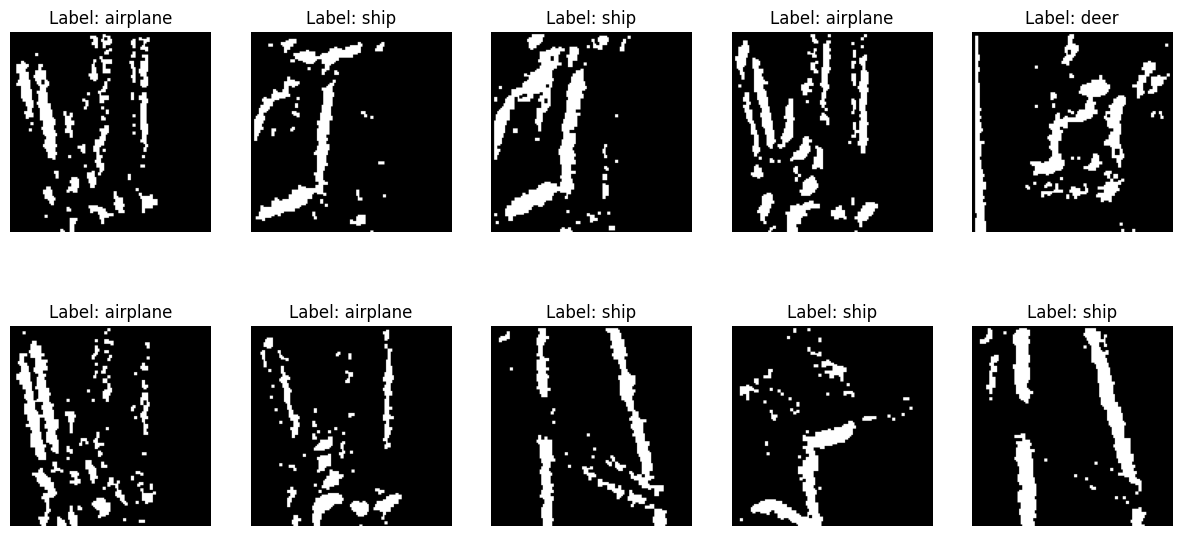

In [75]:
# plot 20 images from ds_images with the label as title
samples = ds_images.shuffle(seed=41).select(range(20))
fig, axes = plt.subplots(2, 5, figsize=(15, 7))
for i, ax in enumerate(axes.flatten()):
    img = samples[i]['image']
    label = samples[i]['label']
    ax.imshow(img, cmap='gray')
    ax.set_title(f'Label: {label}')
    ax.axis('off')

In [11]:
# ds_new.set_format(type='torch', columns=['x', 'y', 't', 'p', 'label'])

# def collate_fn(batch: list[dict]) -> tuple[dict, torch.Tensor]:
#     labels = torch.stack([item['label'] for item in batch])
#     features = {
#         'x': torch.stack([item['x'] for item in batch]),
#         'y': torch.stack([item['y'] for item in batch]),
#         't': torch.stack([item['t'] for item in batch]),
#         'p': torch.stack([item['p'] for item in batch])
#     }
#     return features, labels

# dataloader = torch.utils.data.DataLoader(ds_new, batch_size=32, collate_fn=collate_fn)  # type: ignore
